In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import xlsxwriter
from PIL import Image
import os
from PIL.ExifTags import TAGS
import piexif
import random
from os import listdir
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
#read in excel files
xls18 = pd.ExcelFile('NHL 2017-18.xls')
season18 = pd.read_excel(xls18, 'TOT',header=2)
#xls17 = pd.ExcelFile('NHL 2016-17.xls')
#season17 = pd.read_excel(xls17, 'All Sits',header=2)
#shots=pd.read_csv("shots_2017.csv")

In [3]:
season18=season18[season18.columns[~season18.columns.isin(["TOI.1","TOI.2","TOI.3","iCF.1","iCF.2","iFF.1","iHF.1","iPENT2",
                                                  "iPENT5","iPEND2","iPEND5",'CF.1','CA.1','FF.1','FA.1','SF.1','SA.1'
                                                  ,'GF.1','GA.1','GP.1', 'G.1', 'A.1', 'PTS.1', '+/-.1','PIM.1',
                                                  'TOI.4', 'OPS.1', 'DPS.1', 'PS.1','A1'])]]

In [4]:
season18=season18[season18['Cap Hit']>1000000]
season18=season18.reset_index(drop=True)

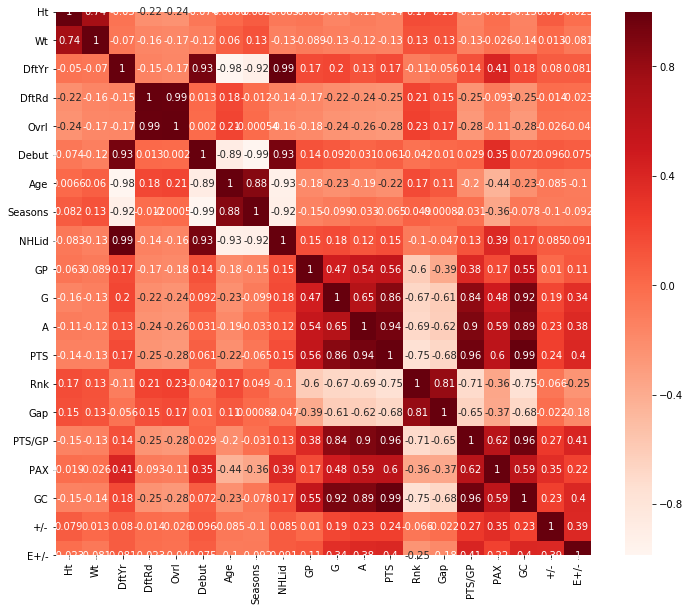

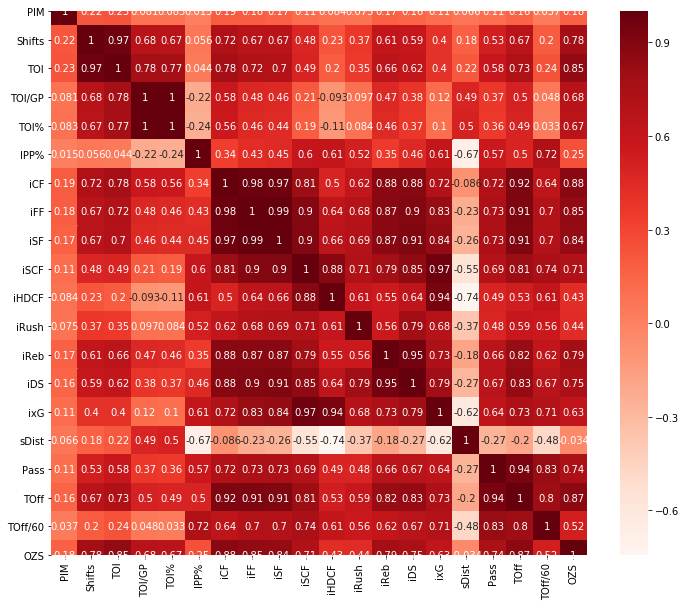

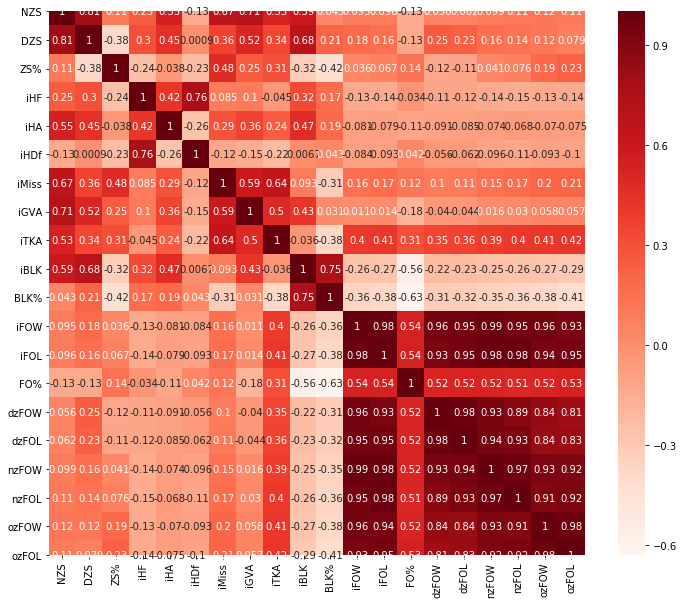

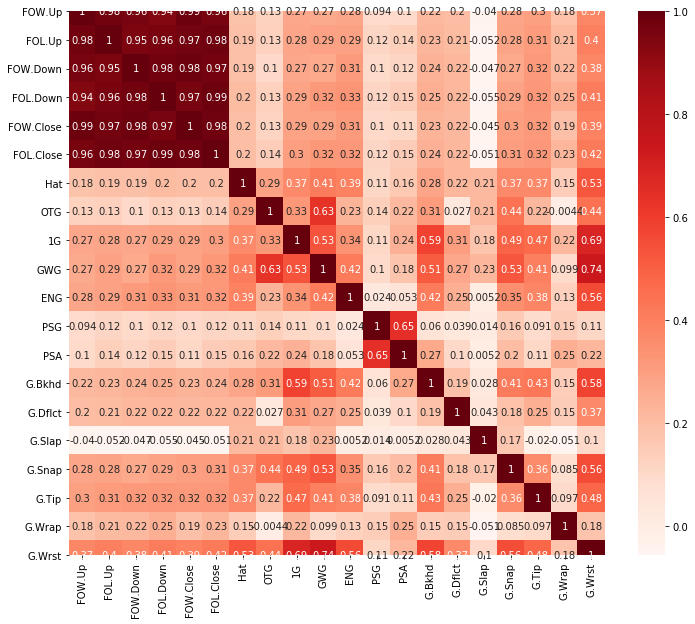

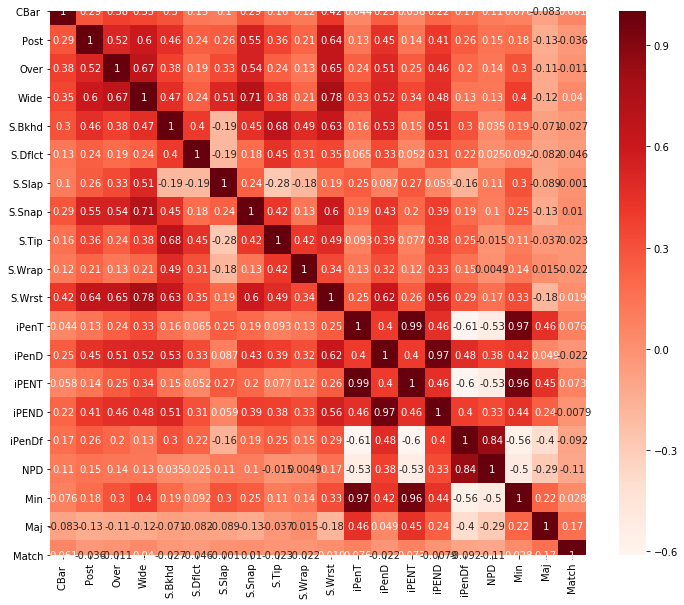

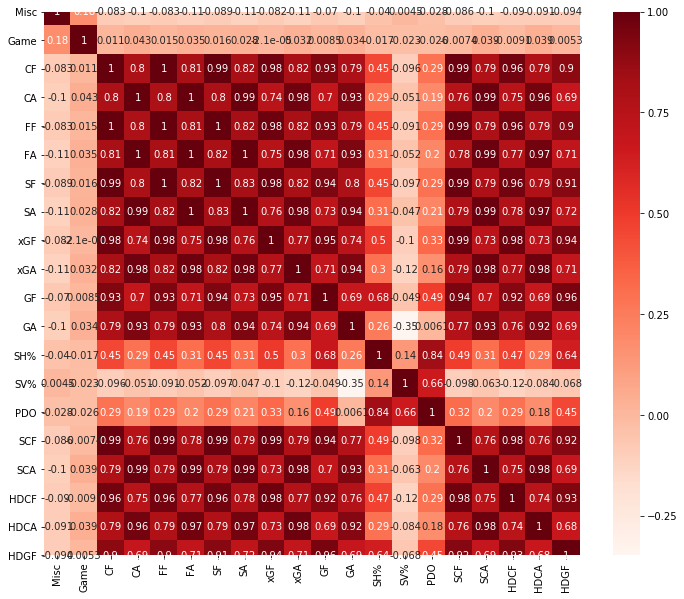

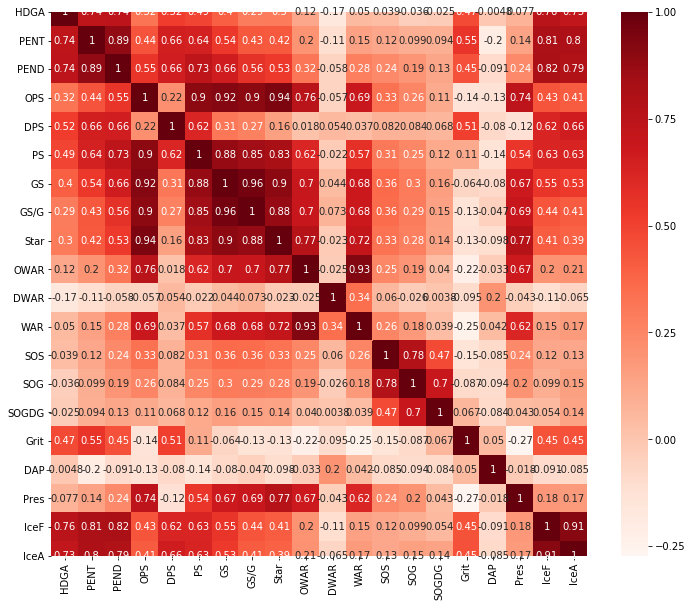

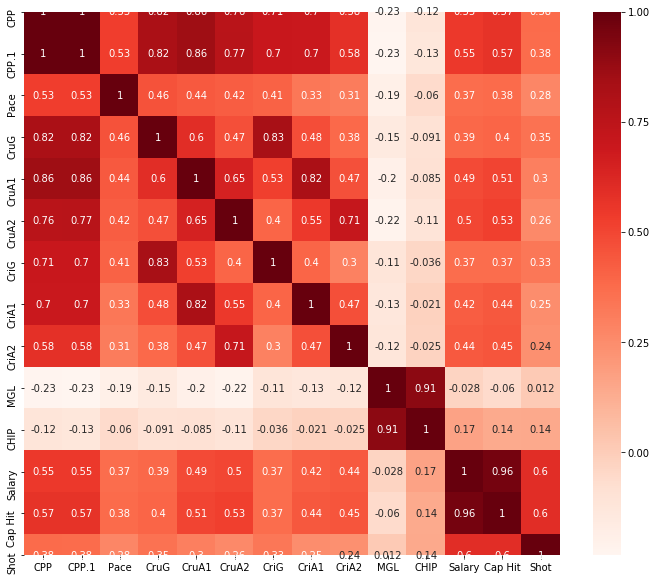

In [5]:
corr = season18.corr()
for i in range(0,int(season18.shape[1]/20)):
    plt.figure(figsize=(12,10))
    sns.heatmap(corr.loc[corr.columns[i*20:i*20+20],corr.columns[i*20:i*20+20]], annot=True, cmap=plt.cm.Reds)
    plt.show()

In [6]:
modelSeason18=season18.copy()
modelSeason18.reset_index(drop=True,inplace=True)

In [7]:
names=modelSeason18['CorsicaID']

In [8]:
modelSeason18.drop(modelSeason18.columns[modelSeason18.dtypes=='object'], axis=1, inplace=True)
modelSeason18.drop(['Born'], axis=1, inplace=True)

In [9]:
modelSeason18.shape

(395, 154)

In [10]:
modelSeason18.fillna('?',inplace=True)

In [11]:
for col in modelSeason18.columns:
    if modelSeason18[col].dtype == object:
        count = 0
        count = [count + 1 for x in modelSeason18[col] if x == '?']
        print(col + ' ' + str(sum(count)))

DftYr 36
DftRd 36
Ovrl 36
SOS 228
SOG 228
SOGDG 228
MGL 131
CHIP 131


In [12]:
modelSeason18.drop(['SOS','SOG','SOGDG','MGL','CHIP','Salary'], axis=1, inplace=True)

In [13]:
for column in modelSeason18.columns:
    modelSeason18.loc[modelSeason18[column] == '?', column] = np.nan
modelSeason18.dropna(axis = 0, inplace = True)
modelSeason18X=modelSeason18.drop(['Cap Hit','NHLid'], axis=1)
modelSeason18Y=modelSeason18[['Cap Hit']]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


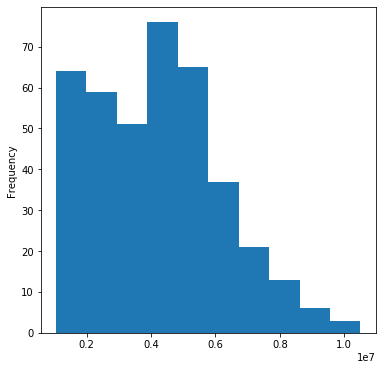

In [14]:
fig = plt.figure(figsize=(6,6)) # define plot area
ax = fig.gca()
season18['Cap Hit'].plot.hist(ax = ax, bins = 10)

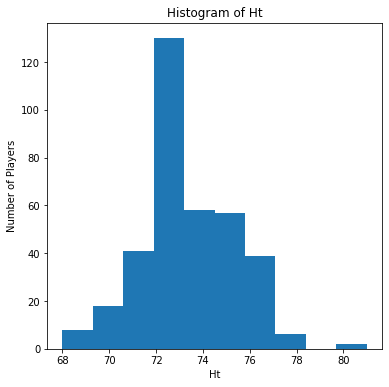

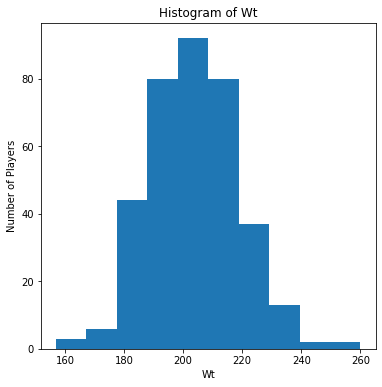

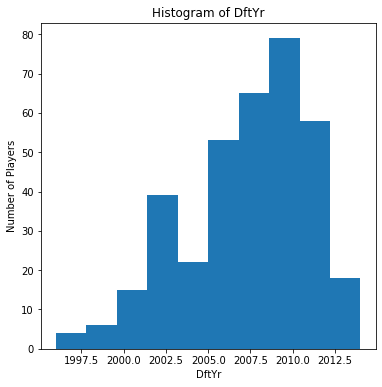

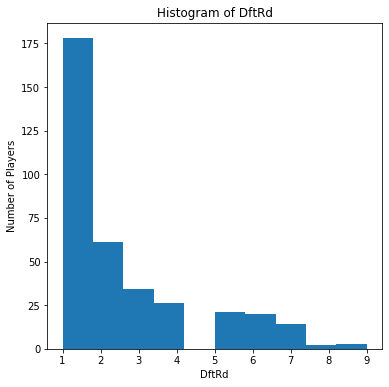

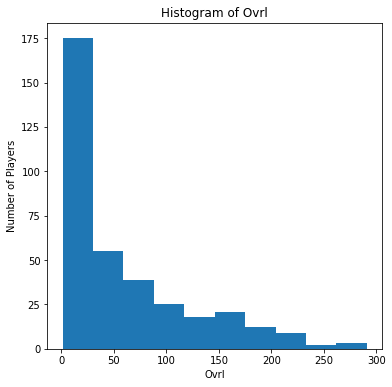

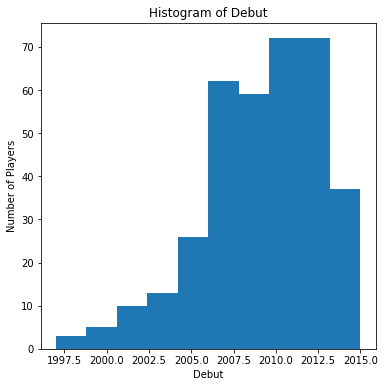

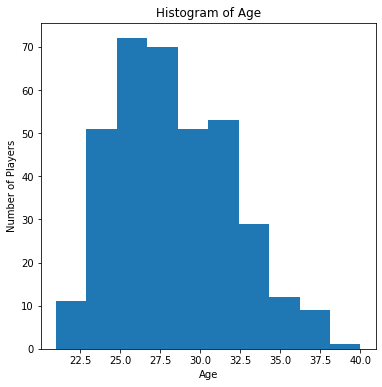

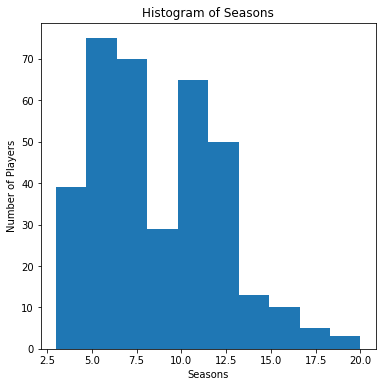

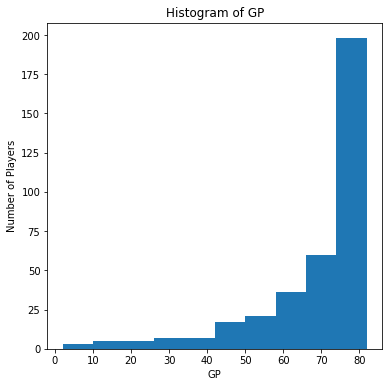

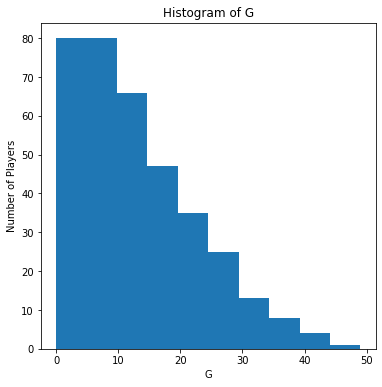

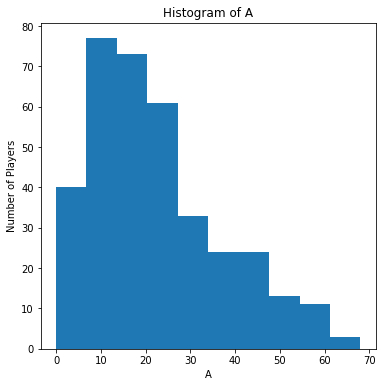

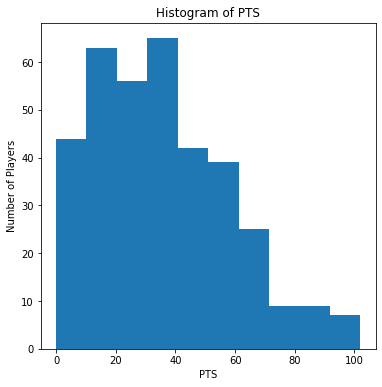

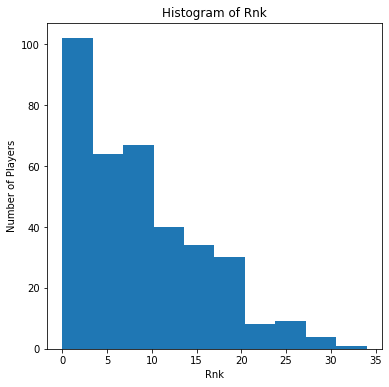

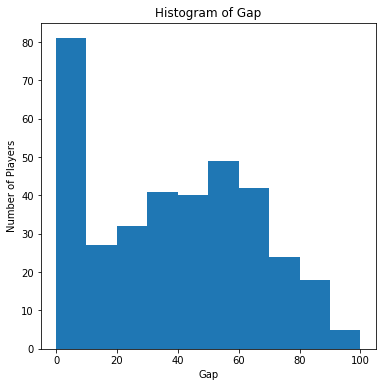

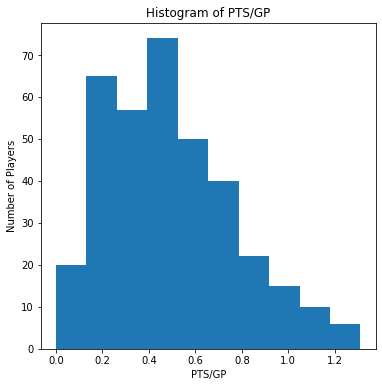

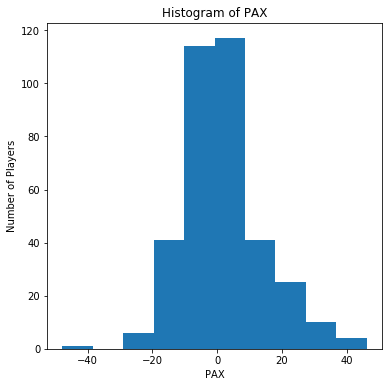

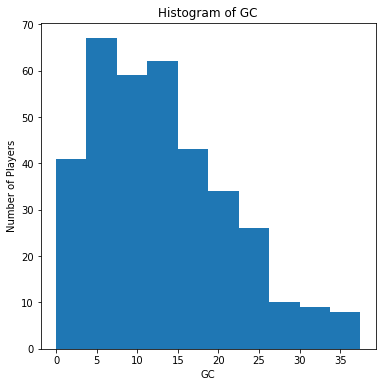

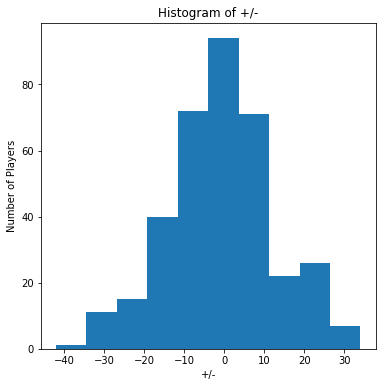

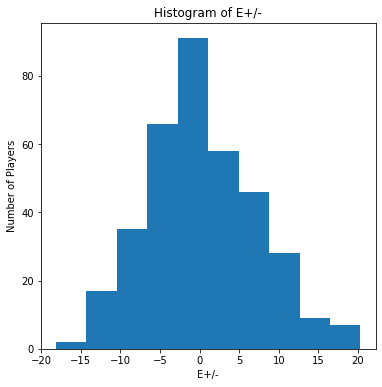

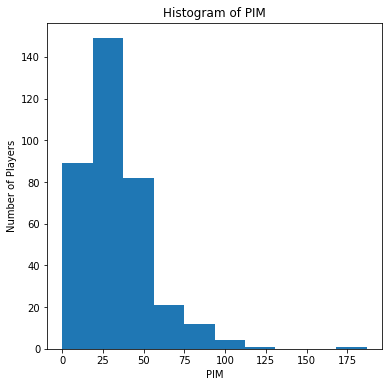

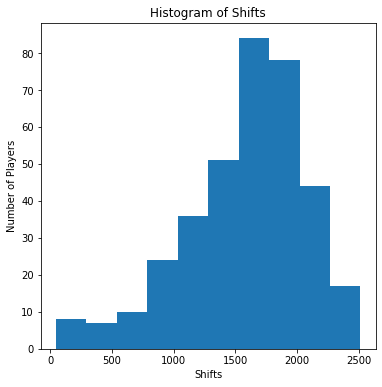

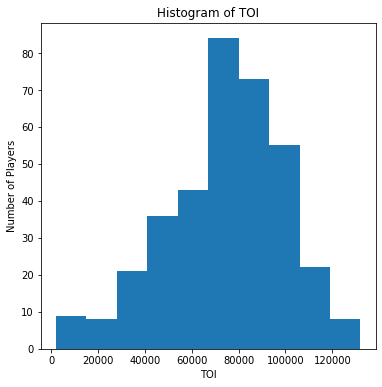

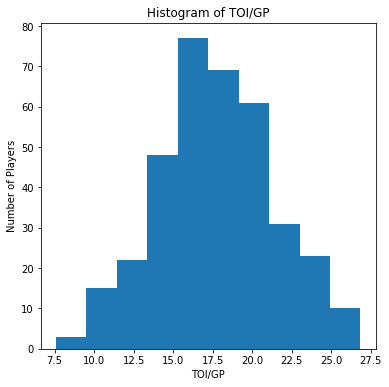

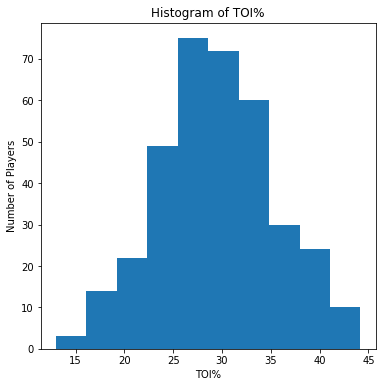

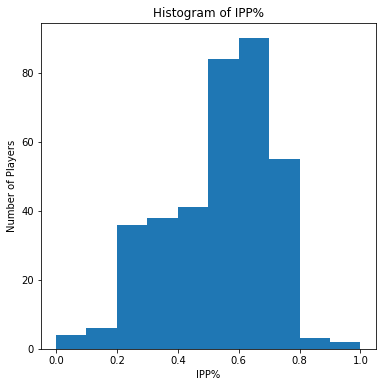

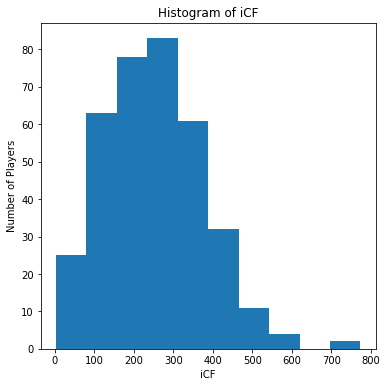

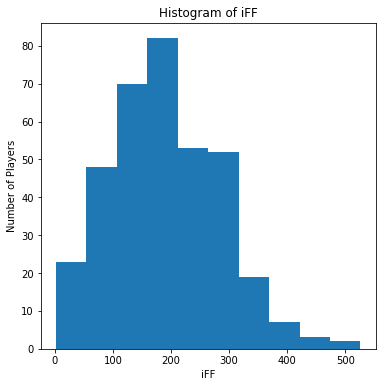

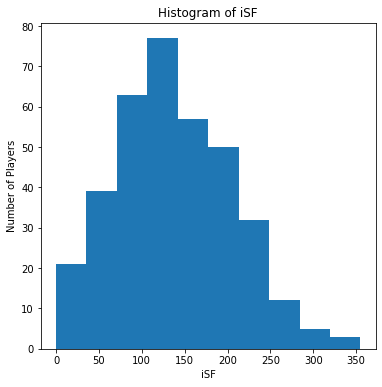

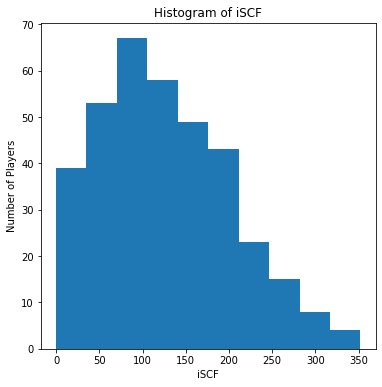

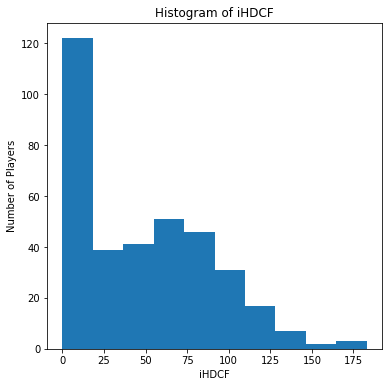

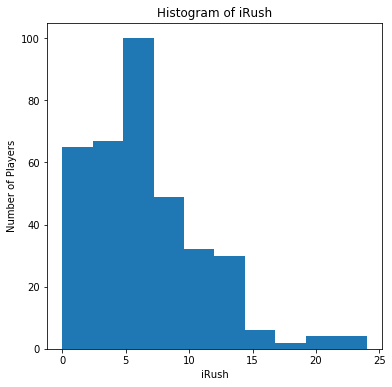

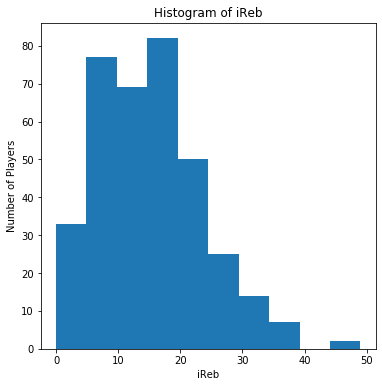

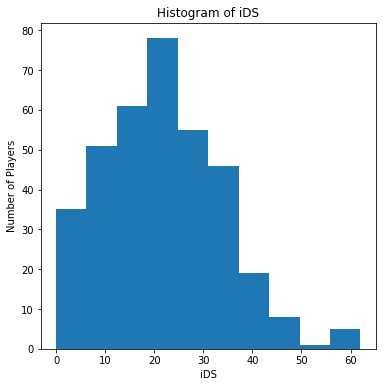

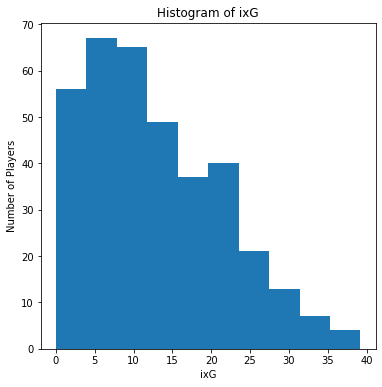

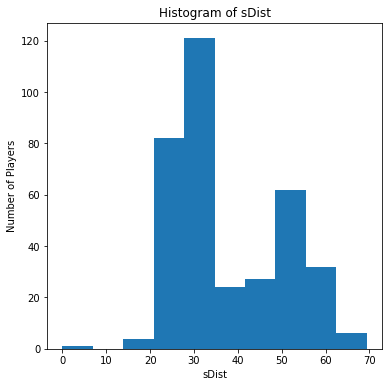

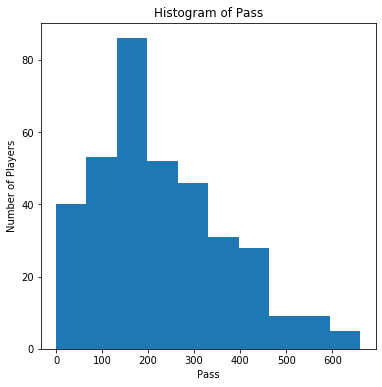

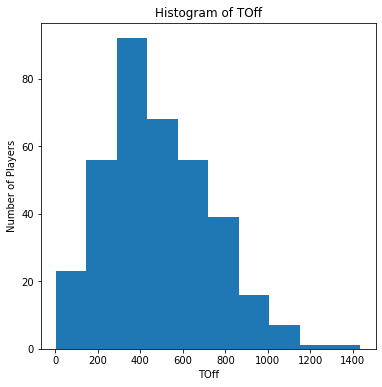

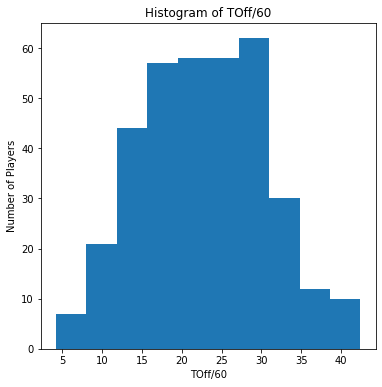

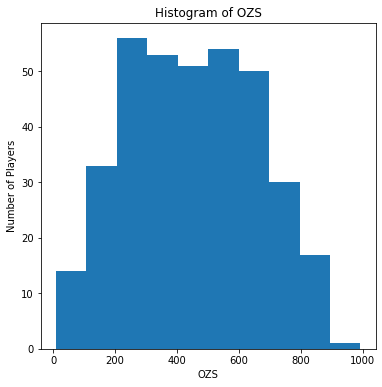

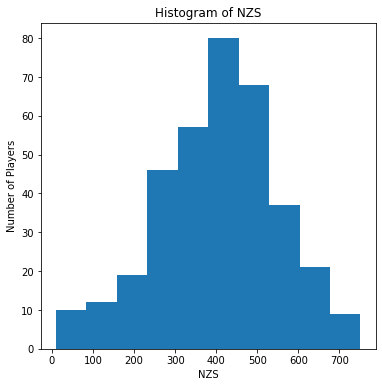

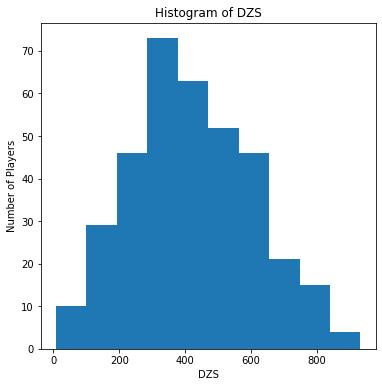

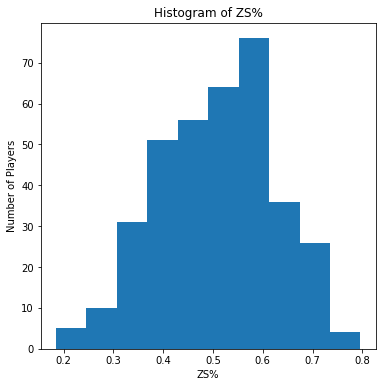

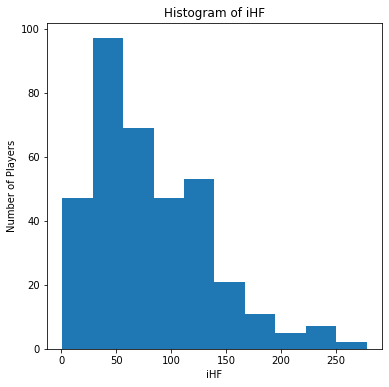

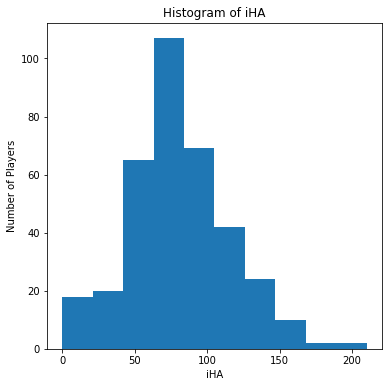

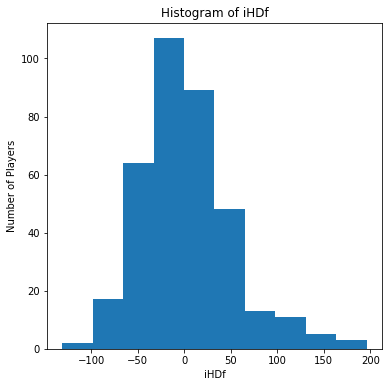

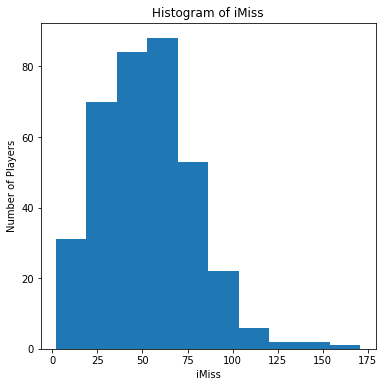

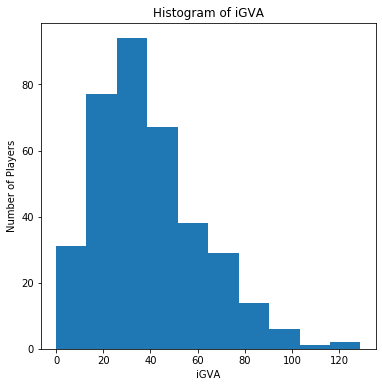

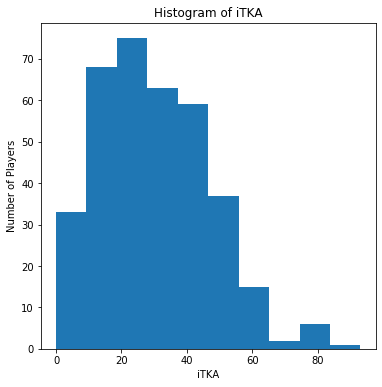

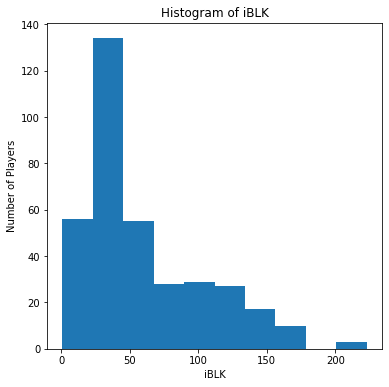

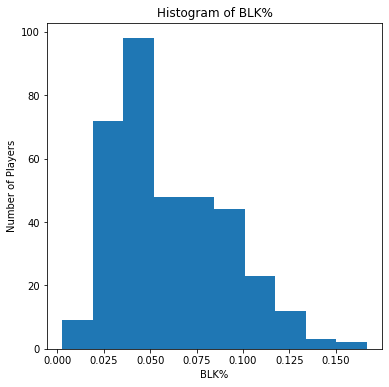

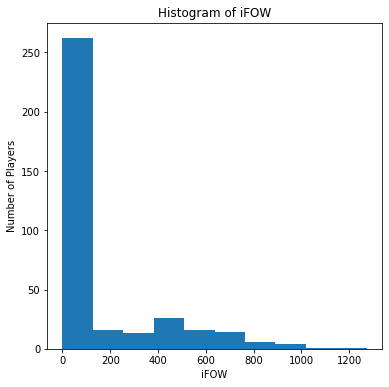

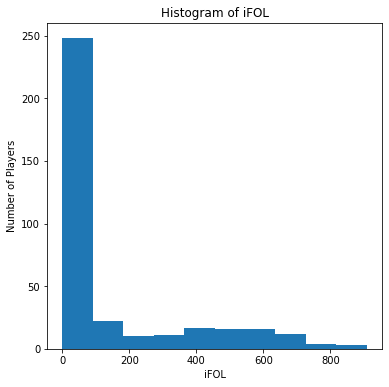

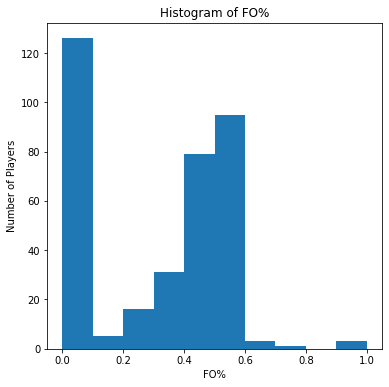

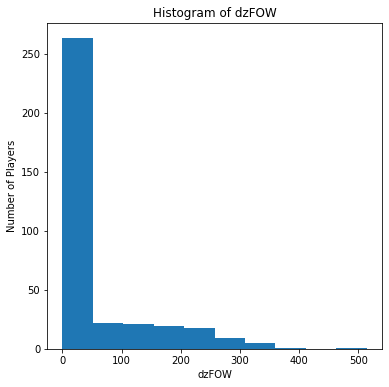

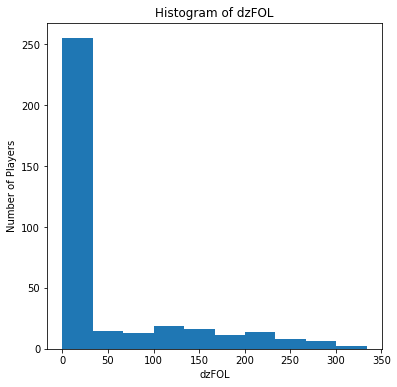

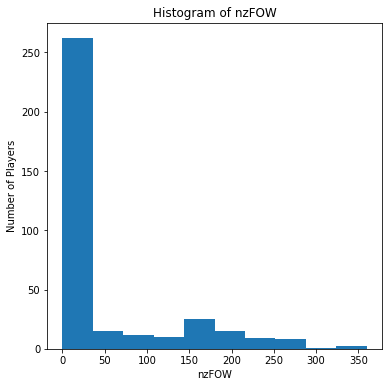

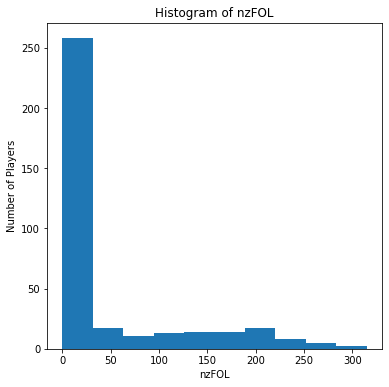

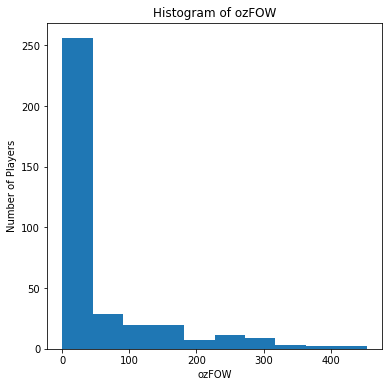

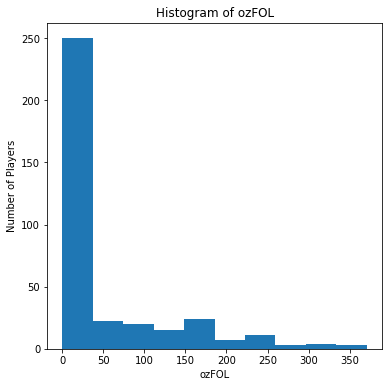

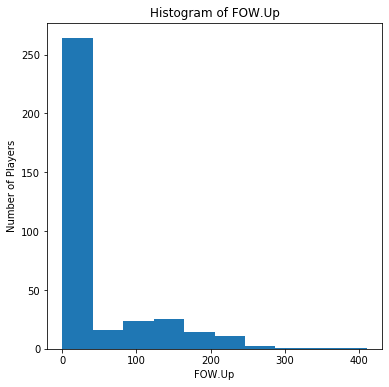

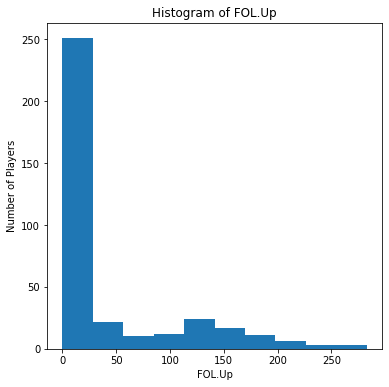

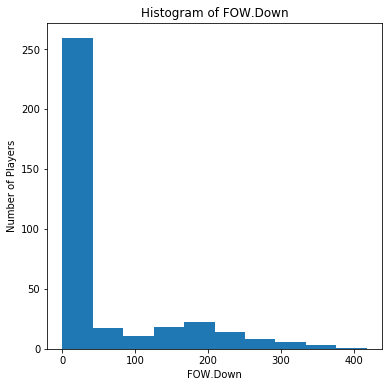

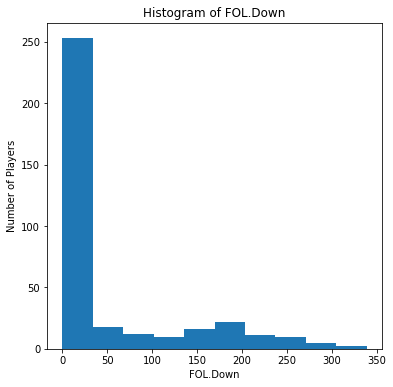

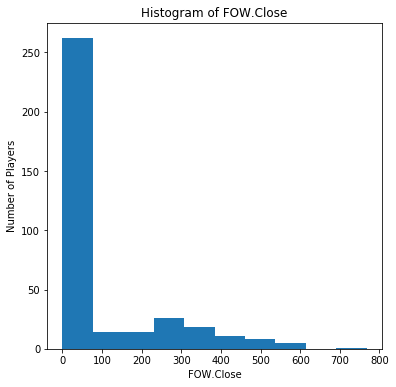

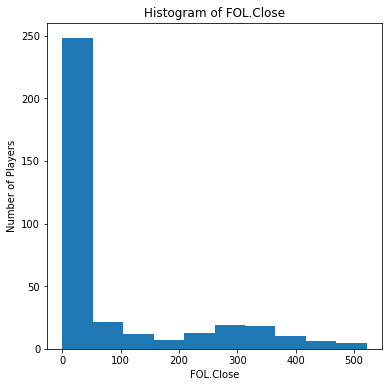

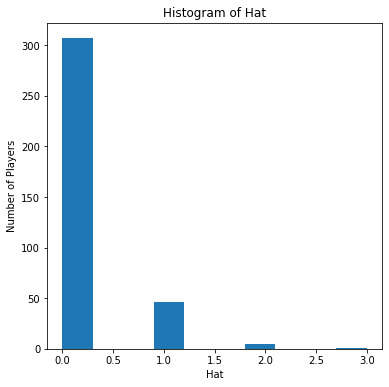

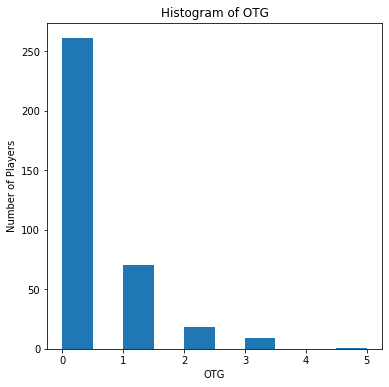

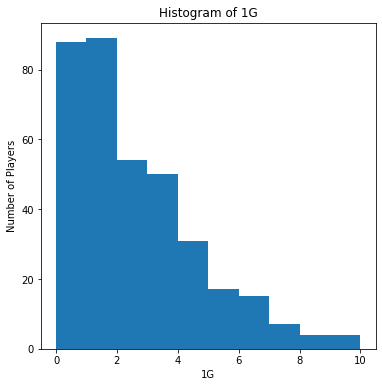

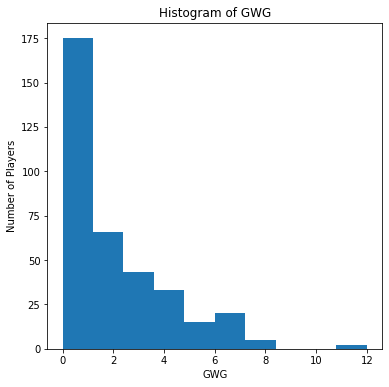

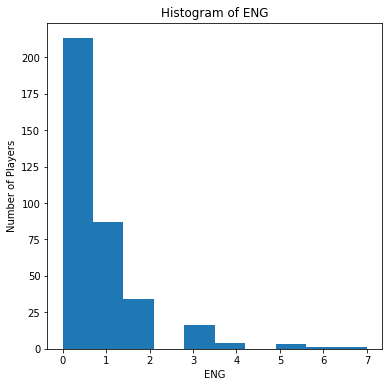

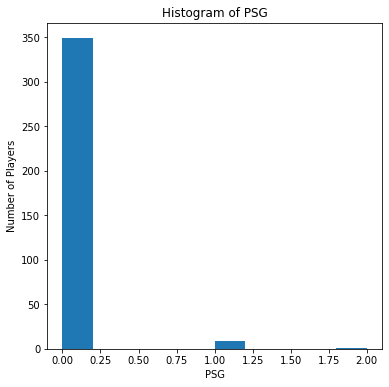

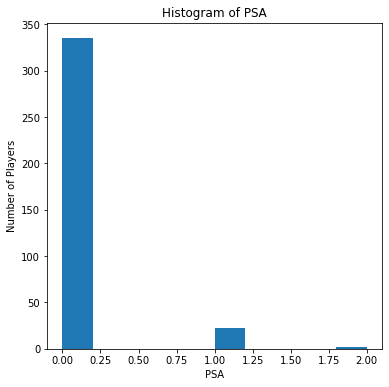

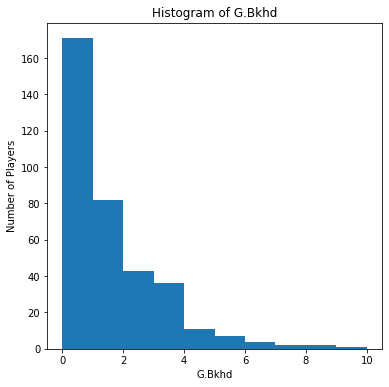

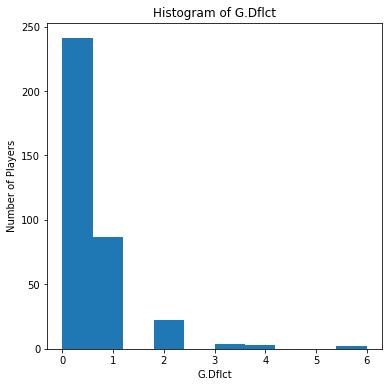

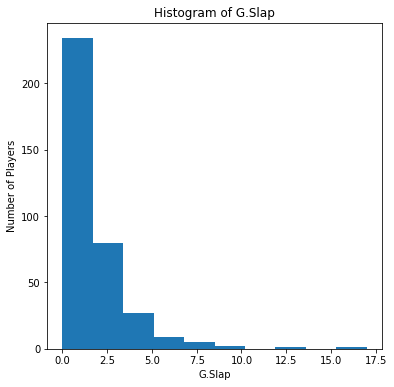

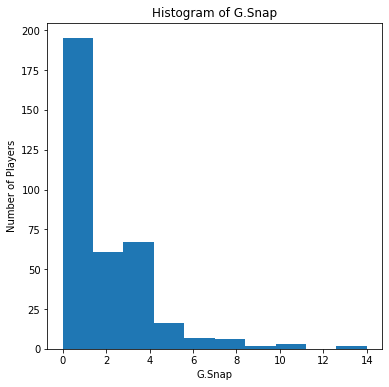

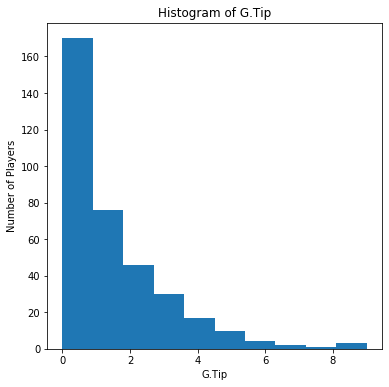

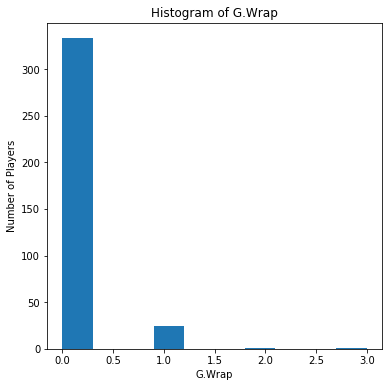

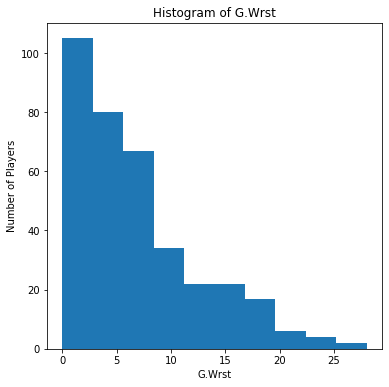

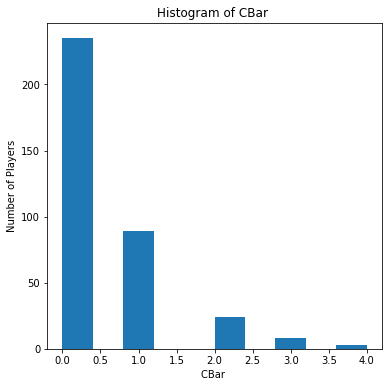

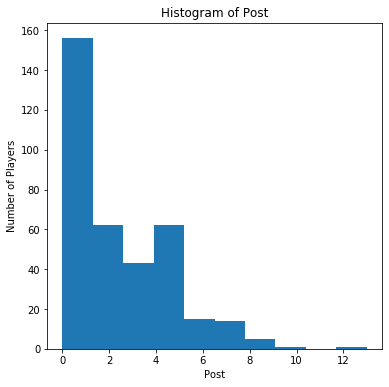

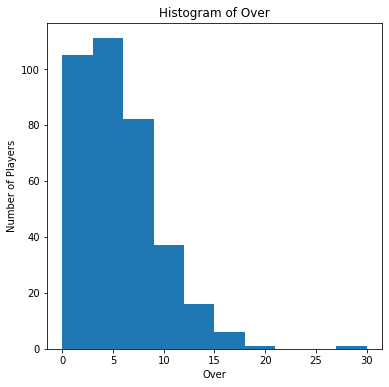

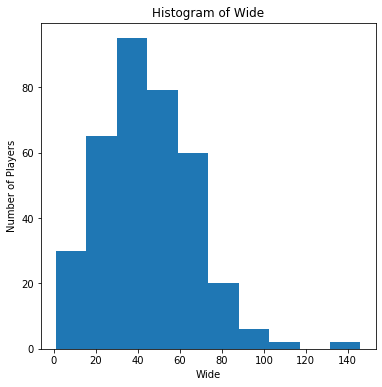

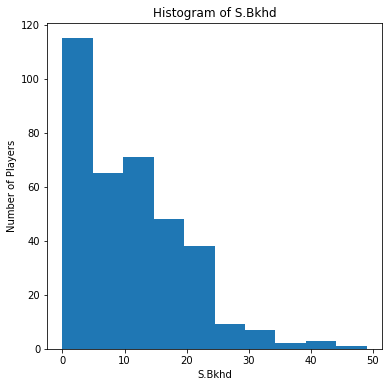

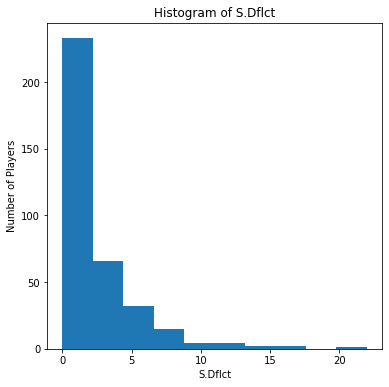

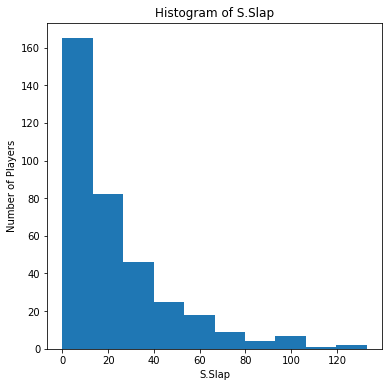

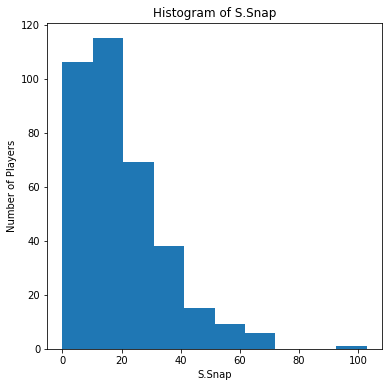

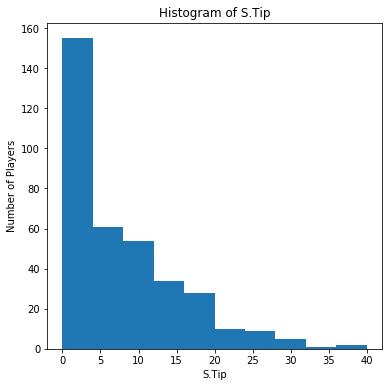

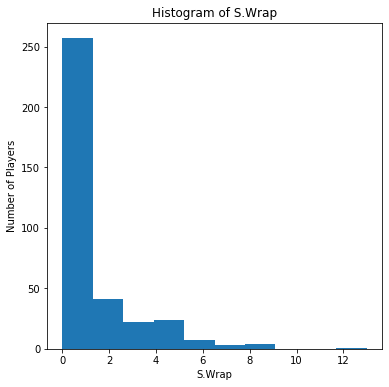

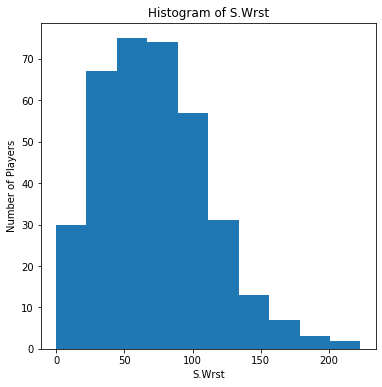

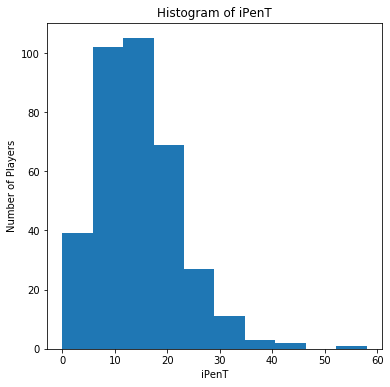

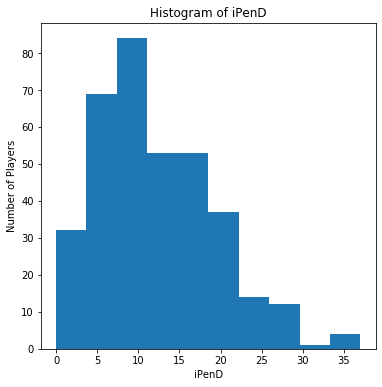

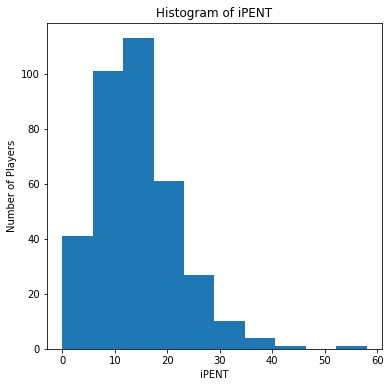

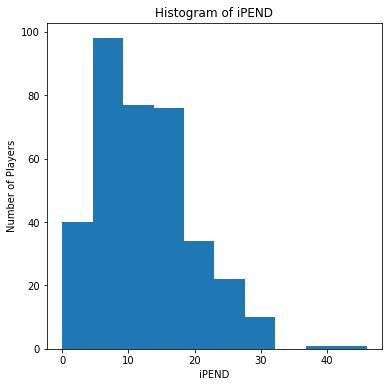

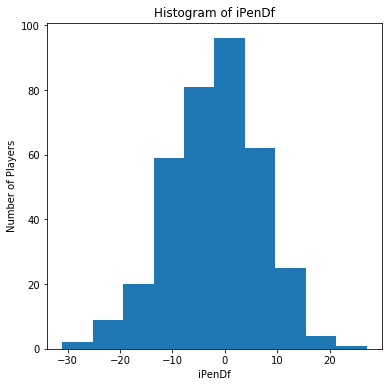

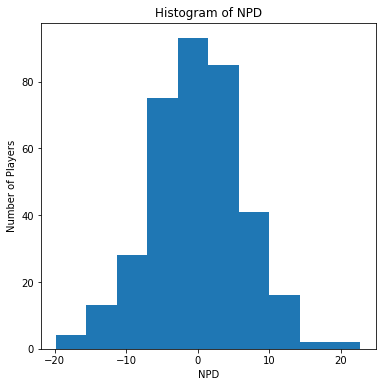

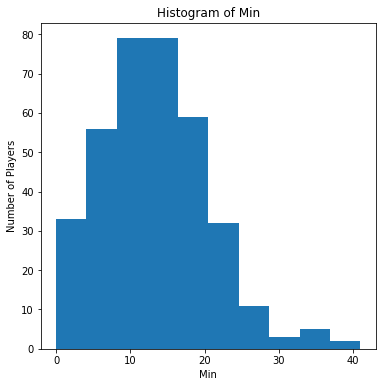

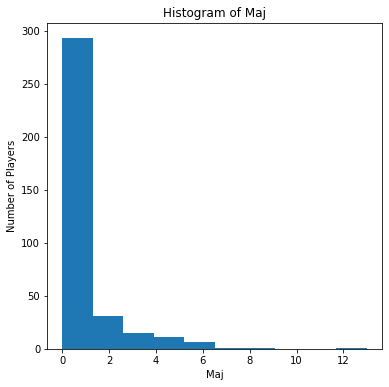

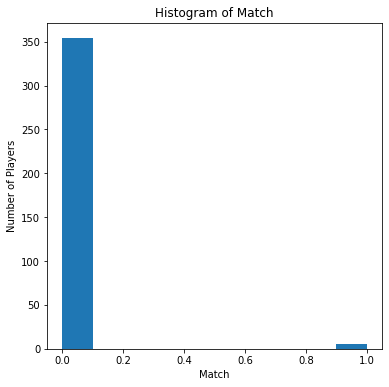

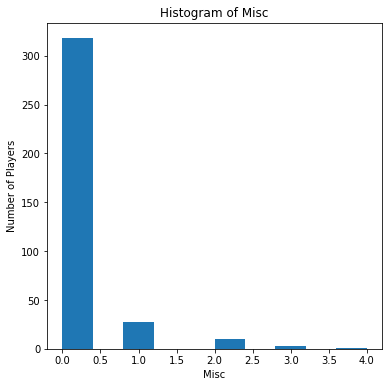

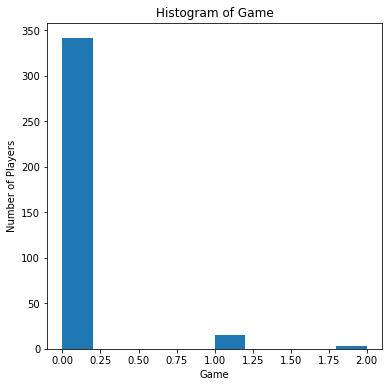

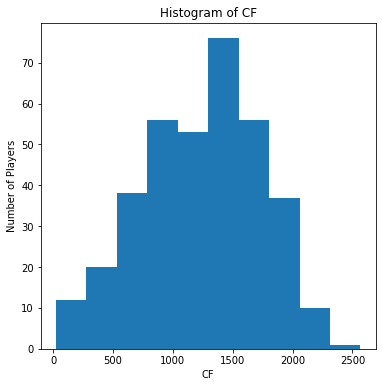

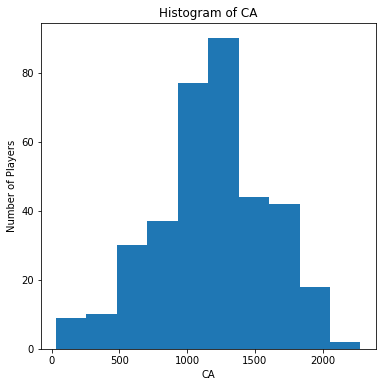

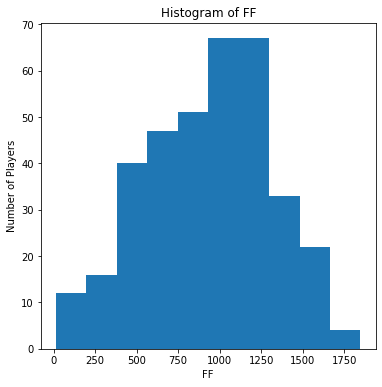

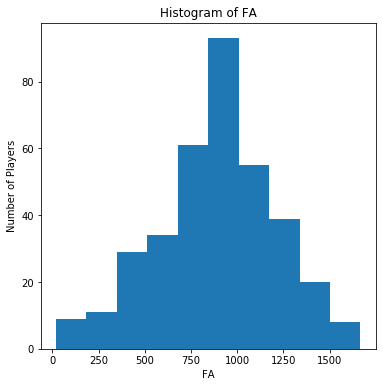

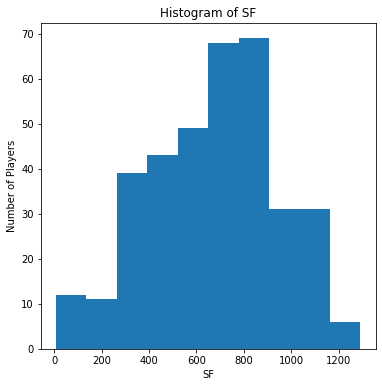

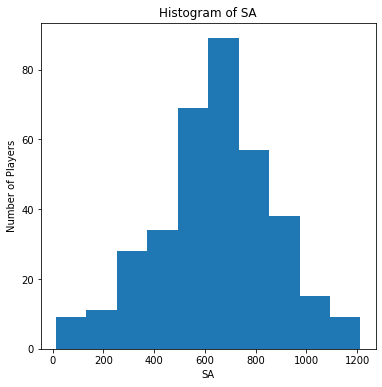

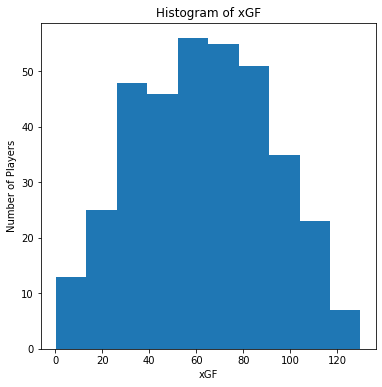

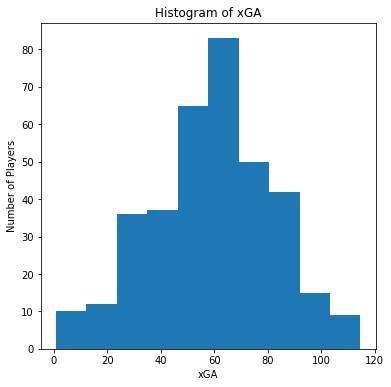

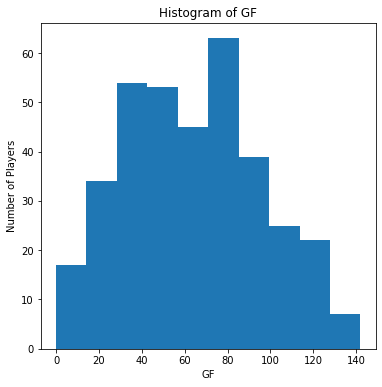

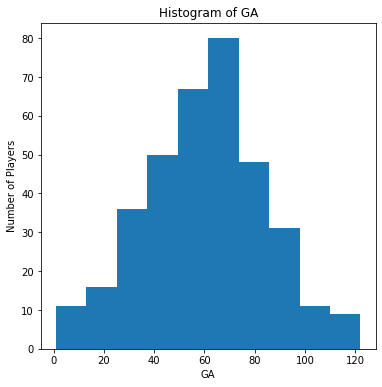

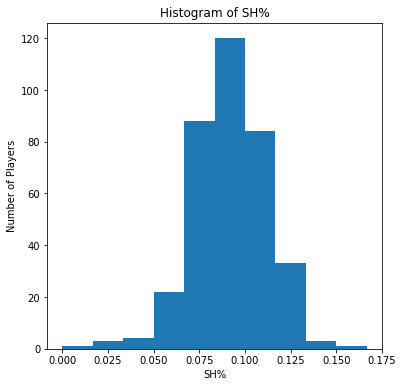

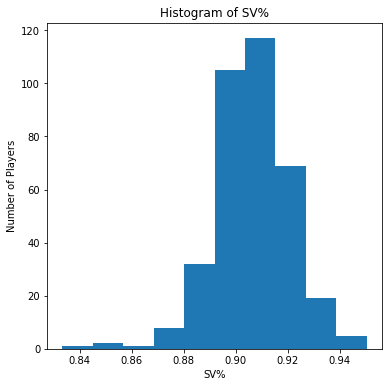

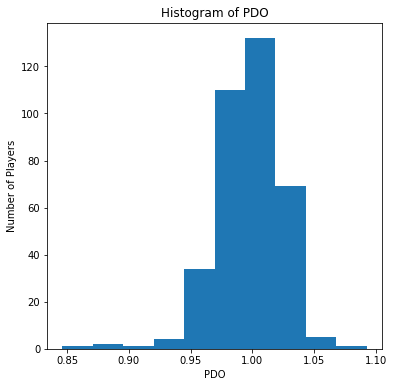

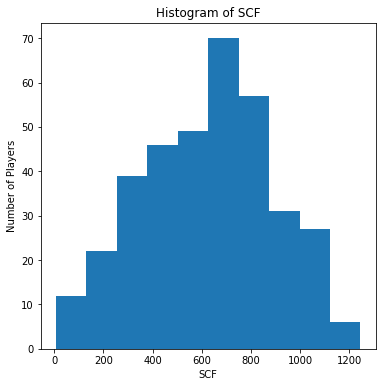

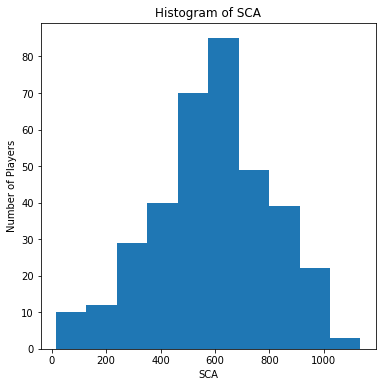

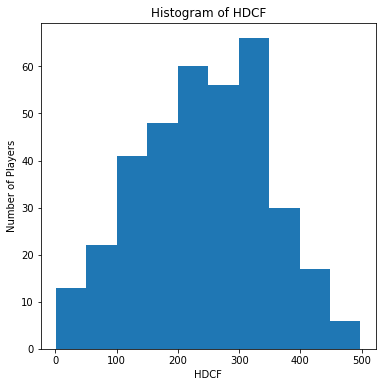

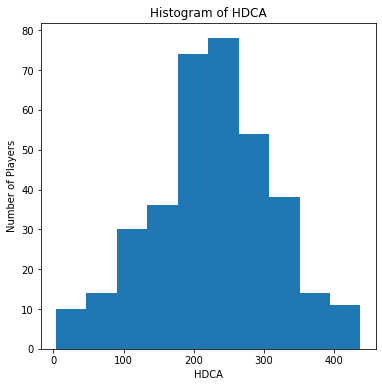

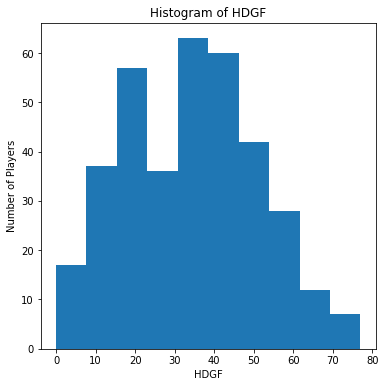

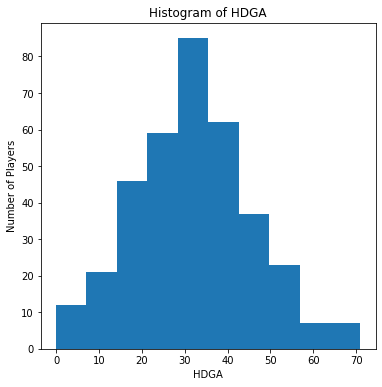

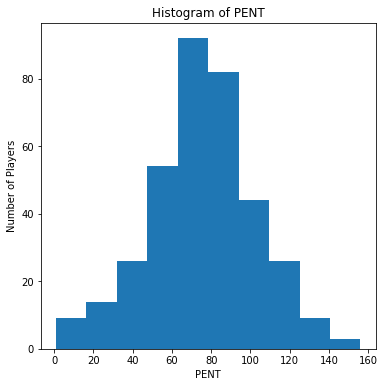

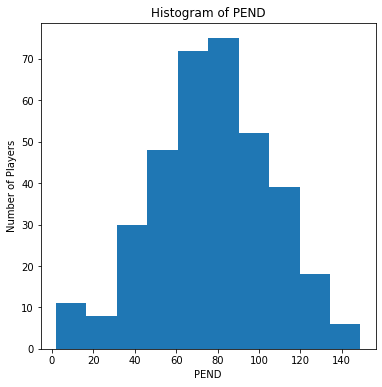

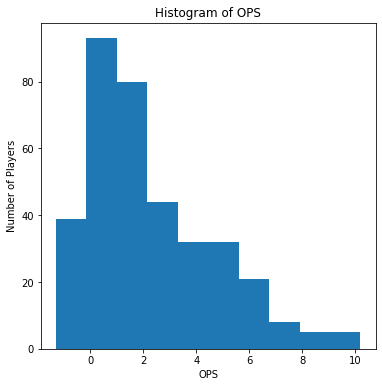

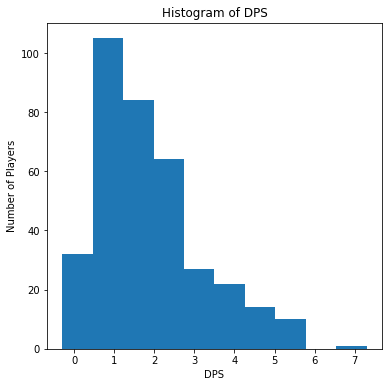

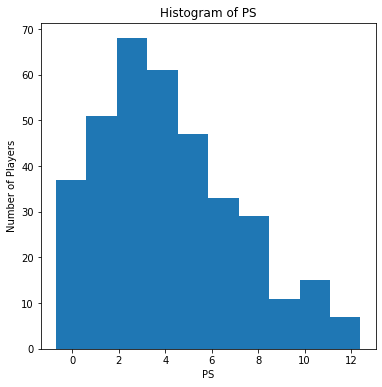

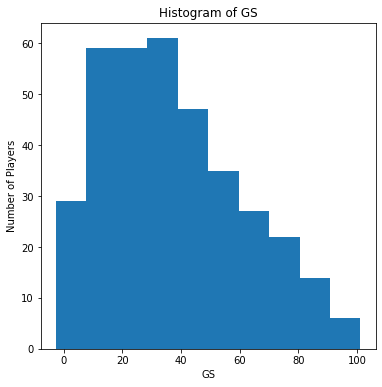

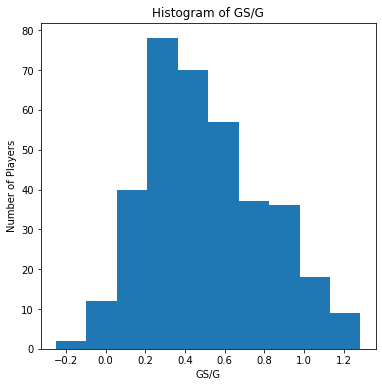

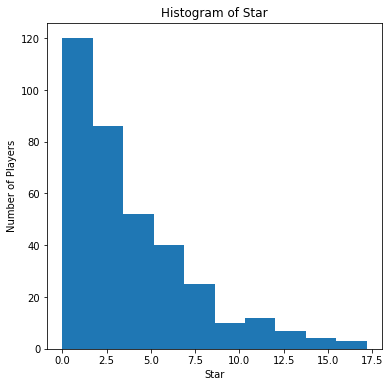

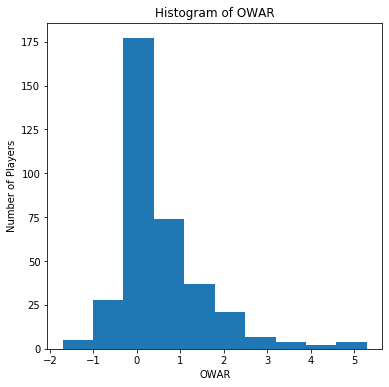

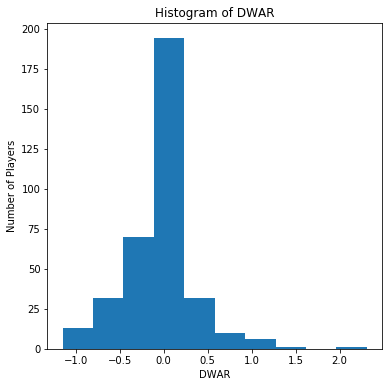

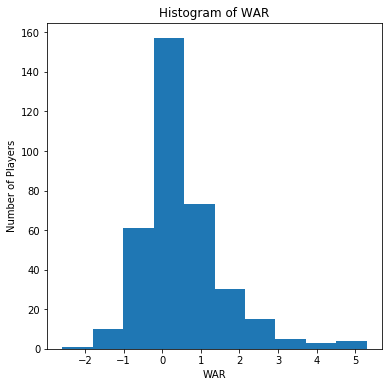

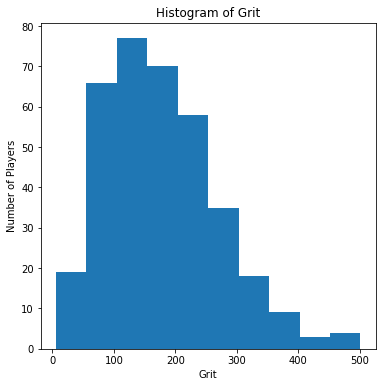

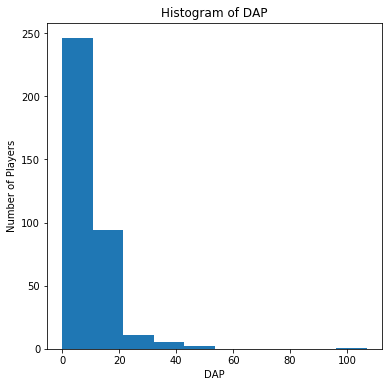

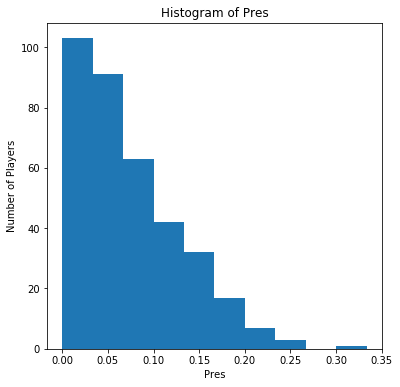

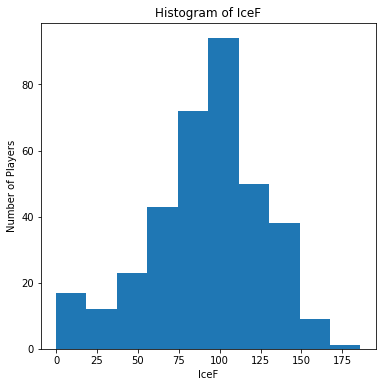

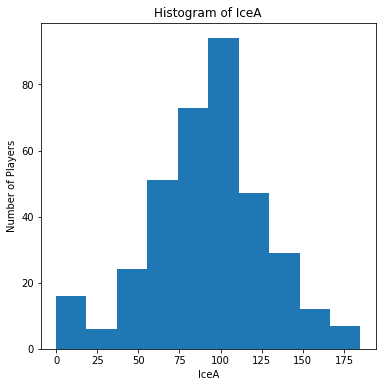

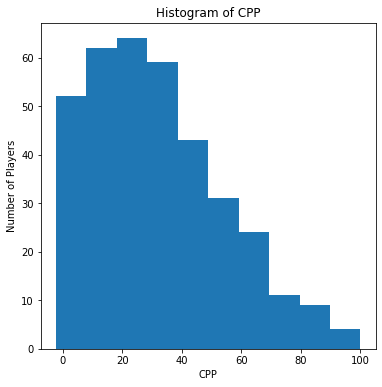

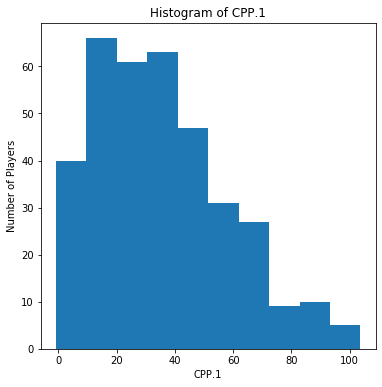

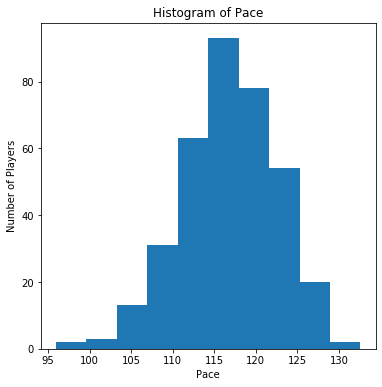

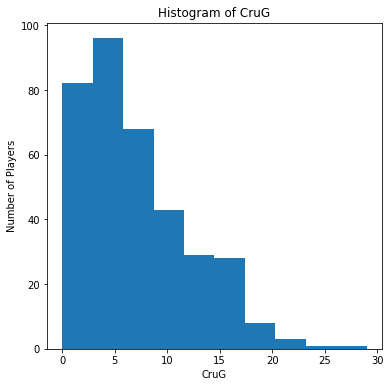

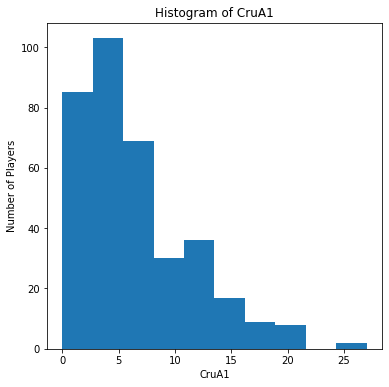

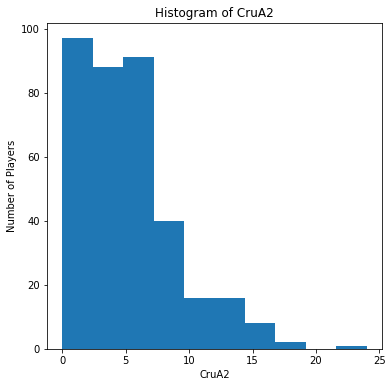

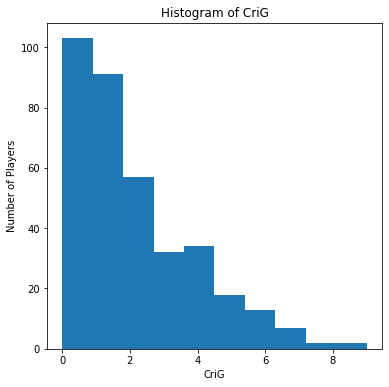

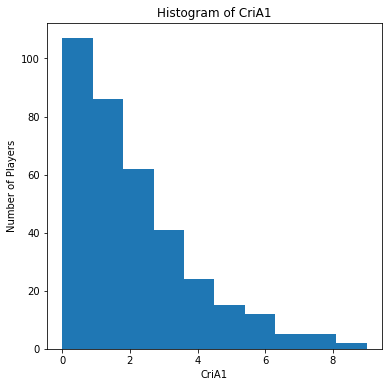

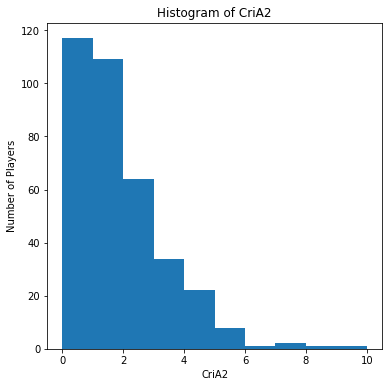

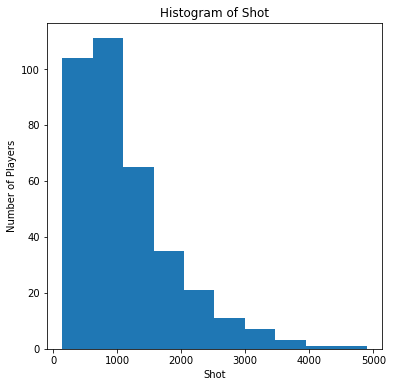

In [15]:
def plot_histogram(season18, cols, bins = 10):
    for col in cols:
        fig = plt.figure(figsize=(6,6)) # define plot area
        ax = fig.gca() # define axis    
        season18[col].plot.hist(ax = ax, bins = bins) # Use the plot.hist method on subset of the data frame
        ax.set_title('Histogram of ' + col) # Give the plot a main title
        ax.set_xlabel(col) # Set text for the x axis
        ax.set_ylabel('Number of Players')# Set text for y axis
        plt.show()
        
num_cols = list(modelSeason18X.columns)
plot_histogram(modelSeason18X, num_cols)

In [16]:
from sklearn import preprocessing

x = modelSeason18X.values
normalized = preprocessing.normalize(x)
modelSeason18X = pd.DataFrame(normalized)

In [17]:
modelSeason18['Cap Hit'].dtypes

dtype('float64')

In [18]:
y=np.log(modelSeason18['Cap Hit'].astype('float64'))

In [19]:
#Backward Elimination
cols = list(modelSeason18X.columns)
pmax = 1
y=np.log(modelSeason18['Cap Hit'].astype('float64'))
count=0
while (len(cols)>0):
    if(count%100==0):
        print(count)
    count=count+1
    p= []
    X_1 = modelSeason18X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(list(y),X_1.astype(float)).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)  
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

0


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


100
[1, 4, 7, 8, 12, 15, 17, 19, 20, 21, 22, 23, 24, 31, 34, 38, 39, 41, 43, 44, 48, 54, 60, 91, 104, 107, 111, 112, 113, 117, 119, 125, 126, 131, 136, 138, 139]


In [20]:
season18.columns[selected_features_BE]

Index(['City', 'Nat', 'DftYr', 'DftRd', 'Age', 'CorsicaID', 'Last Name',
       'Position', 'Team', 'GP', 'G', 'A', 'PTS', 'E+/-', 'TOI', 'iCF', 'iFF',
       'iSCF', 'iRush', 'iReb', 'Pass', 'ZS%', 'iTKA', 'G.Wrst', 'iPenD',
       'iPenDf', 'Match', 'Misc', 'Game', 'FA', 'SA', 'SV%', 'PDO', 'HDGF',
       'DPS', 'GS', 'GS/G'],
      dtype='object')

In [21]:
y

0      15.363073
1      15.068274
2      14.914123
4      15.201805
5      15.520259
         ...    
390    15.193437
391    15.201805
392    15.520259
393    15.165437
394    15.687313
Name: Cap Hit, Length: 359, dtype: float64

In [22]:
modelSeason18X=modelSeason18X[selected_features_BE]

In [23]:
len(selected_features_BE)

37

In [24]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [25]:
X_train, X_test, y_train, y_test = train_test_split(modelSeason18X,y, test_size = 0.2, random_state = 0)

In [26]:
#X2_train=X_train[[5, 8, 14, 15, 20, 21, 22, 27, 38, 39, 40, 42, 43, 51, 57, 85, 89, 90, 91, 94, 96, 104, 105, 107, 110, 118, 133, 136, 143]]
#y2_train=y_train.copy()
#X2_test=X_test[[5, 8, 14, 15, 20, 21, 22, 27, 38, 39, 40, 42, 43, 51, 57, 85, 89, 90, 91, 94, 96, 104, 105, 107, 110, 118, 133, 136, 143]]
#y2_test=y_test.copy()

In [27]:
reg = LassoCV()
reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_test,y_test))
coef = pd.Series(reg.coef_, index = X_test.columns)

Best alpha using built-in LassoCV: 0.000010
Best score using built-in LassoCV: 0.423158


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0069848605171962674, tolerance: 0.005549042833874691
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02374379073522448, tolerance: 0.005549042833874691
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the

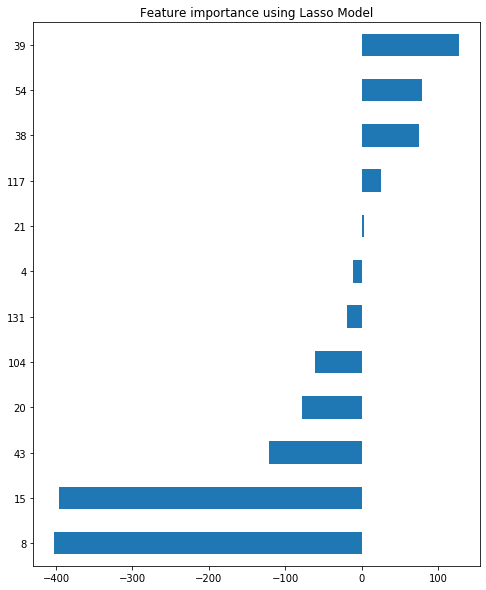

In [28]:
imp_coef = coef.sort_values()
imp_coef=imp_coef[imp_coef!=0]
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

(array([ 2.,  1.,  2.,  1., 13., 16., 13., 12.,  8.,  4.]),
 array([-68979.14930421, -58050.74653314, -47122.34376206, -36193.94099099,
        -25265.53821992, -14337.13544884,  -3408.73267777,   7519.6700933 ,
         18448.07286438,  29376.47563545,  40304.87840652]),
 <a list of 10 Patch objects>)

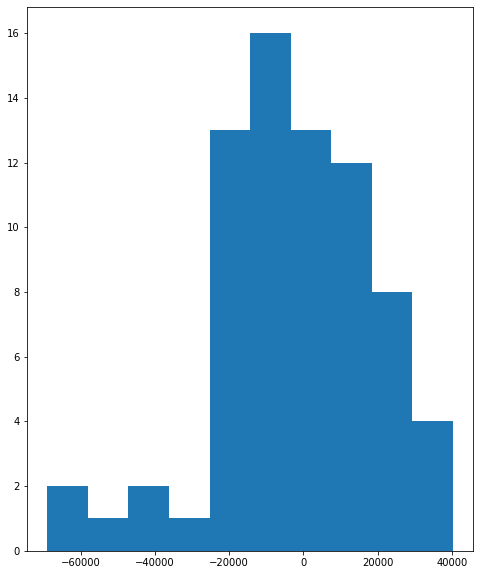

In [29]:
plt.hist((np.exp(reg.predict(X_test))-np.exp(y_test))/len(y_test))

(array([17., 21., 13., 10.,  3.,  3.,  2.,  0.,  2.,  1.]),
 array([  639.34688252,  7473.32712469, 14307.30736686, 21141.28760903,
        27975.2678512 , 34809.24809337, 41643.22833553, 48477.2085777 ,
        55311.18881987, 62145.16906204, 68979.14930421]),
 <a list of 10 Patch objects>)

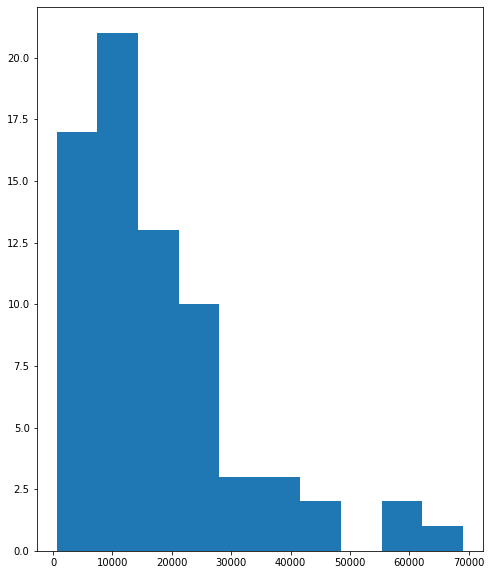

In [30]:
plt.hist((abs(np.exp(reg.predict(X_test))-np.exp(y_test)))/len(y_test))

In [31]:
diff=np.exp(reg.predict(X_test))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-3298983.1714620152
-182861.12537744362
2140488.7958273804
16


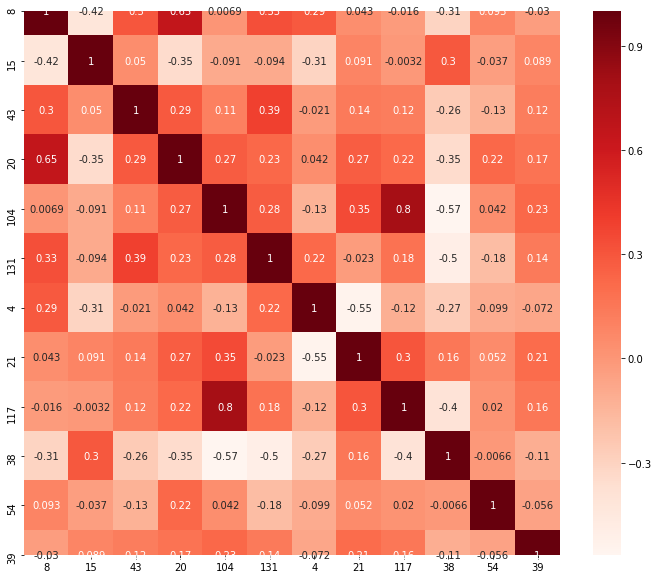

In [32]:
corr = modelSeason18X[imp_coef.index].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr.loc[corr.columns,corr.columns], annot=True, cmap=plt.cm.Reds)
plt.show()

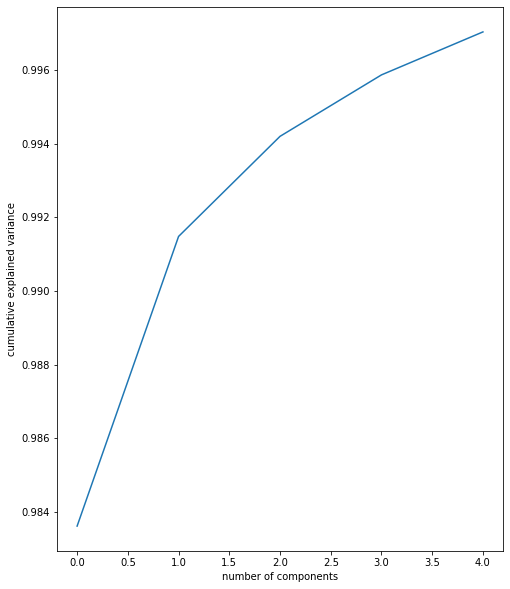

In [33]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_)[0:5])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [34]:
pca=PCA(2)
pca.fit(X_train)
pcatrain_x = pca.transform(X_train)
pcatest_x = pca.transform(X_test)
reg = LassoCV()
reg.fit(pcatrain_x, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [35]:
diff=np.exp(reg.predict(pcatest_x))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))
print(reg.score(pcatest_x, y_test))

-4843070.480642417
-270251.901812898
2430155.4388192226
19
0.08983287128991946


In [36]:
import xgboost as xgb
dtrain=xgb.DMatrix(X_train,y_train)
dtest=xgb.DMatrix(X_test,y_test)
params={
    'objective':"reg:squarederror",
    'eval_metric':["rmse","mae"]
}
evallist=[(dtest,'eval'),(dtrain,'train')]

In [37]:
num_round = 1000
bst=xgb.train(params,dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-rmse:10.26212	eval-mae:10.24631	train-rmse:10.28330	train-mae:10.26957
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 10 rounds.
[1]	eval-rmse:7.19870	eval-mae:7.17614	train-rmse:7.21897	train-mae:7.19940
[2]	eval-rmse:5.05599	eval-mae:5.02382	train-rmse:5.07496	train-mae:5.04708
[3]	eval-rmse:3.54984	eval-mae:3.50892	train-rmse:3.57686	train-mae:3.54307
[4]	eval-rmse:2.51288	eval-mae:2.46055	train-rmse:2.52988	train-mae:2.48727
[5]	eval-rmse:1.78889	eval-mae:1.72040	train-rmse:1.80080	train-mae:1.74721
[6]	eval-rmse:1.29835	eval-mae:1.20879	train-rmse:1.29292	train-mae:1.23193
[7]	eval-rmse:0.97888	eval-mae:0.88443	train-rmse:0.93271	train-mae:0.87582
[8]	eval-rmse:0.75236	eval-mae:0.66435	train-rmse:0.68307	train-mae:0.62288
[9]	eval-rmse:0.61735	eval-mae:0.54051	train-rmse:0.50068	train-mae:0.44809
[10]	eval-rmse:0.53448	eval-mae:0.45471	train-rmse:0.37531	train-mae:0.32324
[11]	eval-rmse:0

In [38]:
xgbPred=bst.predict(dtest,ntree_limit=bst.best_ntree_limit)

In [39]:
diff=np.exp(xgbPred)-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))


-3378508.2499999963
34259.500000000466
2014407.7499999993
19


In [40]:
from sklearn.metrics import mean_squared_error
mean_squared_error(xgbPred,y_test)

0.17916546255441518

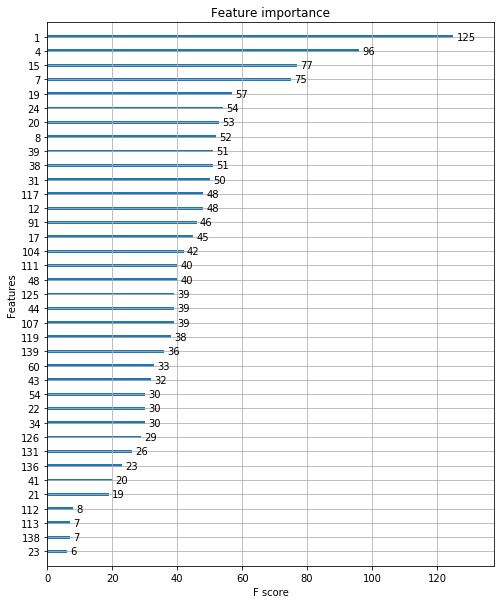

In [41]:
xgb.plot_importance(bst)

(array([ 3.,  1.,  2.,  3., 11., 12., 13., 14.,  7.,  6.]),
 array([-4.7665905, -4.0313106, -3.2960307, -2.5607508, -1.8254709,
        -1.090191 , -0.3549111,  0.3803688,  1.1156487,  1.8509286,
         2.5862085]),
 <a list of 10 Patch objects>)

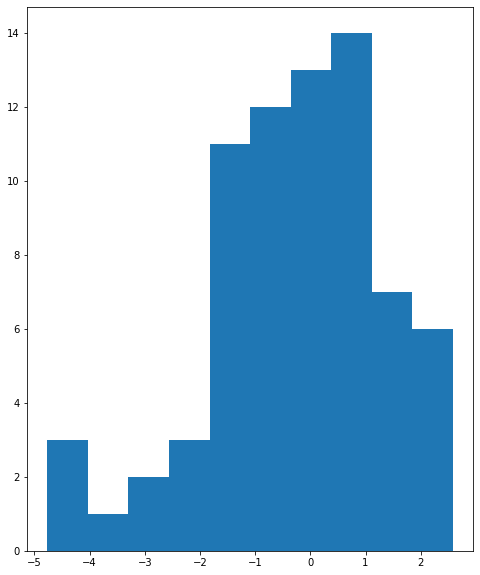

In [42]:
plt.hist((diff)/1000000)

In [43]:
len(diff[abs(diff)<500000])

19

In [44]:
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-3378508.2499999963
34259.500000000466
2014407.7499999993
19


In [45]:
from sklearn.tree import DecisionTreeRegressor

dtree=DecisionTreeRegressor()
#dtree.fit(X2_train,y2_train)
dtree.fit(X_train,y_train)

#diff=dtree.predict(X2_test)-y2_test
diff=np.exp(dtree.predict(X_test))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)

(array([ 1.,  2.,  2.,  4.,  4., 18., 22., 12.,  2.,  5.]),
 array([-6999999.99999999, -5854999.99999999, -4709999.99999999,
        -3564999.99999999, -2419999.99999999, -1274999.99999999,
         -130000.        ,  1015000.        ,  2160000.        ,
         3305000.        ,  4450000.        ]),
 <a list of 10 Patch objects>)

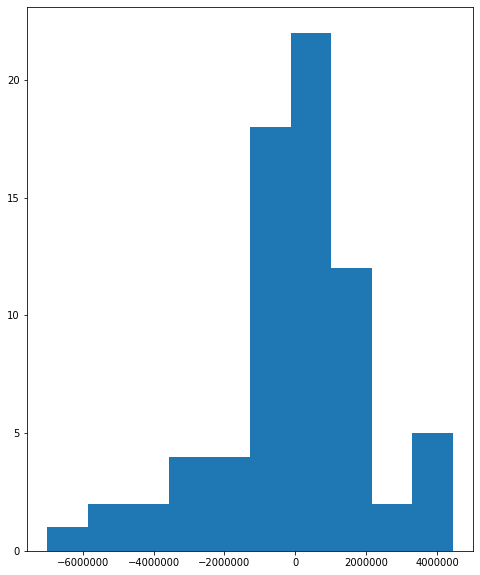

In [46]:
plt.hist(diff)

In [47]:
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-3800000.000000003
299999.99999999534
3400000.000000002
18


In [48]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf')
svr.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [49]:
diff=np.exp(svr.predict(X_test))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
sum(diff)/len(y_test)

-29901.09661435597

In [50]:
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-4745256.315450802
154096.8630132242
3104067.7584633874
20


In [51]:
len(diff[abs(diff)<500000])/len(diff)

0.2777777777777778

In [52]:
from sklearn.linear_model import SGDRegressor

sgd=SGDRegressor(max_iter=1000, tol=1e-3)
sgd.fit(X_train,y_train)
sgd.score(X_test,y_test)

-0.006827244057464155

In [53]:
diff=np.exp(sgd.predict(X_test))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-5066740.586088413
-188843.2860776214
2742636.632694753
15


In [54]:
from sklearn.ensemble import BaggingRegressor

model = BaggingRegressor()
model.fit(X_train,y_train)

diff=np.exp(model.predict(X_test))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

print(model.score(X_test,y_test))

-2499100.5464316765
-233500.43323733984
2140336.64987077
15
0.4684438909753905


(array([ 1.,  1.,  1.,  1., 11.,  7., 18., 14., 13.,  5.]),
 array([-5733125.04542475, -4905988.0882867 , -4078851.13114866,
        -3251714.17401061, -2424577.21687257, -1597440.25973452,
         -770303.30259647,    56833.65454157,   883970.61167962,
         1711107.56881766,  2538244.52595571]),
 <a list of 10 Patch objects>)

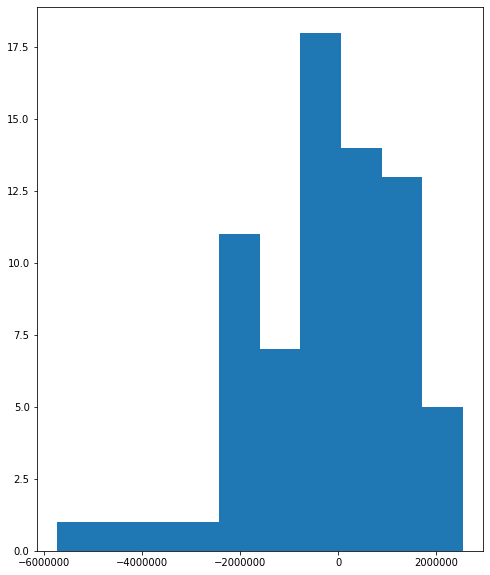

In [55]:
plt.hist(diff)

In [56]:
np.std(diff)

1553881.206038655

In [59]:
model = BaggingRegressor()
model.fit(X_train,y_train)

diff=np.exp(model.predict(X_test))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

print(model.score(X_test,y_test))

-2330584.545989165
3257.1628396362066
2101727.2880980726
16
0.4743746922009292


(array([ 2.,  1.,  0.,  6., 11., 12., 10., 17.,  7.,  6.]),
 array([-4667758.52962073, -3941904.63564544, -3216050.74167015,
        -2490196.84769486, -1764342.95371958, -1038489.05974429,
         -312635.165769  ,   413218.72820628,  1139072.62218157,
         1864926.51615686,  2590780.41013214]),
 <a list of 10 Patch objects>)

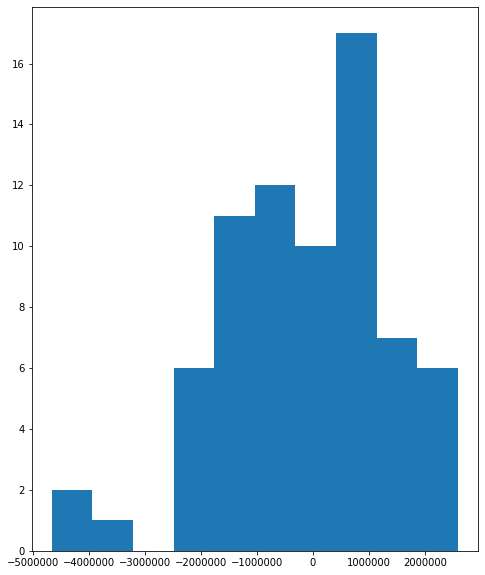

In [60]:
plt.hist(diff)

In [61]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=1000000).fit(X_train, y_train)
regr.predict(X_test)
regr.score(X_test, y_test)

-0.03882246625926111

In [62]:
diff=np.exp(regr.predict(X_test))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-5282229.666722799
-326103.7722970587
2739362.455847431
14
